# Analyzing the NYC Subway Dataset

Craig Nicholson
September 9th 2015

In this notebook, we will review look the NYC Subway data and determine if more people ride the subway when it is raining versus when it is not raining.

## Imports

In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels as sm
from scipy.stats import ttest_ind

In [22]:
# display plot within the notebook rather than a new window
%pylab inline

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load the Data

In [3]:
# load the stroopdata.csv
path = '~/Downloads/P2-1/turnstile_weather_v2.csv'
df = pd.read_csv(path)

In [4]:
# fetch two samples, the one with rain and the one without rain
# 1 = rain, 0 = no rain for the entry
rain = df[df['rain']==1]
norain =  df[df['rain']==0]

## Section 1. Statistical Test

The mean difference of people ride the subway when it is raining versus when it is not raining.

#### null Hypothesis
H0: μd = μ0


#### Alternate Hypothesis
HA: μd ≠ μ0

#### Statistical Test
Since we have one large sample and are reviewing riders on the days it is raining vs. not raining we will run an Independant T-test.  And the ENTRIESn_hourly occurs over a date range.

#### Independant variables
Rain vs No Rain

#### Dependent variable
The number of ENTRIESn_hourly

## Data Validation

In [5]:
rain.head(5)

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
16,R003,05-04-11,00:00:00,4391507,2913223,83,174,2011-05-04 00:00:00,0,2,...,29.94,1,59.0,9.2,0.01,29.953333,53.933333,11.7,40.700348,-73.887177
17,R003,05-04-11,04:00:00,4391531,2913258,24,35,2011-05-04 04:00:00,4,2,...,29.91,1,60.1,0.0,0.01,29.953333,53.933333,11.7,40.700348,-73.887177
18,R003,05-04-11,08:00:00,4392063,2913388,532,130,2011-05-04 08:00:00,8,2,...,29.94,1,55.4,15.0,0.01,29.953333,53.933333,11.7,40.700348,-73.887177
19,R003,05-04-11,12:00:00,4392517,2913495,454,107,2011-05-04 12:00:00,12,2,...,29.96,1,51.1,11.5,0.01,29.953333,53.933333,11.7,40.700348,-73.887177
20,R003,05-04-11,16:00:00,4392764,2913744,247,249,2011-05-04 16:00:00,16,2,...,29.96,1,48.0,18.4,0.01,29.953333,53.933333,11.7,40.700348,-73.887177


any mising dates  
are all dates valid  
any missing ENTRIESn_hourly  
any missing hours, any hours out of the correct date?  
we have day_week can we use this for the weekend   
do we have folks using more UNITs in other areas more than others...   
what happens on the weekend with the data...  
when it rains does it rain for all hours in the day or just like early in the AM...
what is the hourly entries like throughout the day... 


## Calculations

In [6]:
# t-test via scipy  - run this first , and then review and calculate to learn the math
# returns t-statistic and two-tailed p-value
t_test_results = stats.ttest_ind(norain['ENTRIESn_hourly'],rain['ENTRIESn_hourly'],equal_var = False)
t_statistic = t_test_results[0]
p_value = t_test_results[1]

In [7]:
# Get the (n) number of samples in each 
rain_n = rain['UNIT'].count() 
norain_n = norain['UNIT'].count() 

# Get the means and medians for the rain
rain_xbar= rain['ENTRIESn_hourly'].mean()
rain_median = rain['ENTRIESn_hourly'].median()

# Get the means and medians for the norain
norain_xbar = norain['ENTRIESn_hourly'].mean()
norain_median = norain['ENTRIESn_hourly'].median()

# Get the standard deviations of the samples
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
rain_sd = stats.tstd(rain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))
norain_sd = stats.tstd(norain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))

# Standard Error of the Mean
# I need to run this calculations myself and valiate the independant test
rain_se = stats.sem(rain['ENTRIESn_hourly'], axis=None, ddof=1)
norain_se = stats.sem(norain['ENTRIESn_hourly'], axis=None, ddof=1)

In [8]:
# Calculate the t-critical value, instead of using a table - woohoo
# http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.t.html
# By adding 1 to 0.95 and then dividing by 2, we get the critical value for 2 tail test
degrees_of_freedom = (rain_n + norain_n) - 2
critical_value = stats.t._ppf((1+0.95)/2., degrees_of_freedom)
critical_value = stats.t._ppf((1+0.99)/2., degrees_of_freedom)

In [9]:
# Calculate Sum of Squares (SS for rain), pooled var, pooled SE
# (X1 - XBar)**2
rain_SS = np.sum((rain['ENTRIESn_hourly']-rain_xbar)**2)
norain_SS = np.sum((norain['ENTRIESn_hourly']-norain_xbar)**2)
rain_SS, norain_SS
pooled_varience = (rain_SS+norain_SS)/((rain_n-1)+(norain_n-1))
pooled_SD = (rain_SS+norain_SS) / ((norain_n-1)+(rain_n-1))
pooled_SE = np.sqrt(pooled_varience/rain_n + pooled_varience/norain_n)
t_stat_check = (rain_xbar-norain_n)/pooled_SE

In [10]:
rain_small = rain['ENTRIESn_hourly']
#rain_small['diff_mean_var']  = rain['ENTRIESn_hourly']-rain_xbar
#rain_small['xbar'] = rain_xbar
#rain_small['diff'] = rain_small['ENTRIESn_hourly'] - rain_small['xbar']
#rain_small['diff_mean_var'].head(5)
#rain_small['SS'] = np.square(rain_small['diff'])

In [11]:
# Cohens D
cohens_d = (rain_xbar-norain_xbar)/pooled_SD

In [12]:
# Calculate Confidence Intervals
lower_CI = 0
upper_CI = 0

In [14]:
print 'DESCRIPTIVE STATISTICS'
print '\t\tn \t\tmean \t\tmedian \t\tStDev \t\tSE Mean'
print 'Rain   \t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (rain_n,rain_xbar, rain_median,rain_sd,rain_se)
print 'No Rain\t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (norain_n,norain_xbar,norain_median,norain_sd,norain_se)
print '\n'
print 'We need pooled varience: %.3f' % pooled_varience
print 'We need pooled standard deviation: %.3f' % pooled_SD
print 'We need pooled standard error %.3f' % pooled_SE
print '\n'

print 'INFERENTIAL STATISTICS'
# Paired t-test, two tail
# t-statistic
# df 
# p-value
# direction of test (two tail, or one tail to in _/- directrion')
print 'Type of test\t\t\t = %s' % 'Independent t-test'
print 'Test statistics: T \t\t = %.5f' % t_statistic
print 'Degrees of Freedom\t\t = %.0f' % ((rain_n+norain_n)-1)
print 'Significance Level: alpha \t = %s ' % '0.01'
print 'Critical value: t1-α/2,ν \t = %.2f' % critical_value
print 'Critical region: Reject H0 if \t = |T| > %.2f' % critical_value
print 'P-Value\t\t\t\t = %.9f' % p_value
print 'Direction of test\t\t = %s ' % 'two tail'
print '\n'

print 'CONFIDENCE INTERVALS'
print '95%% CI for the mean difference: (%.5f, %.5f)' % (lower_CI,upper_CI)
print 'Margin of Error: %.2f' % ((upper_CI-lower_CI)/2.0)
print '\n'

print 'EFFECT SIZE MEASURES'
# r - ratio - X:Y, 
r_squared = ( np.square(t_statistic) /  (np.square(t_statistic) + (degrees_of_freedom)  ))
print 'r squared \t\t\t = %.5f' % r_squared 
print 'Cohens-D\t\t\t = %.5f' % cohens_d
print '\n'


DESCRIPTIVE STATISTICS
		n 		mean 		median 		StDev 		SE Mean
Rain   		9585.00 	2028.20 	939.00 		3189.43 	32.58
No Rain		33064.00 	1845.54 	893.00 		2878.77 	15.83


We need pooled varience: 8710971.755
We need pooled standard deviation: 8710971.755
We need pooled standard error 34.238


INFERENTIAL STATISTICS
Type of test			 = Independent t-test
Test statistics: T 		 = -5.04288
Degrees of Freedom		 = 42648
Significance Level: alpha 	 = 0.01 
Critical value: t1-α/2,ν 	 = 2.58
Critical region: Reject H0 if 	 = |T| > 2.58
P-Value				 = 0.000000464
Direction of test		 = two tail 


CONFIDENCE INTERVALS
95% CI for the mean difference: (0.00000, 0.00000)
Margin of Error: 0.00


EFFECT SIZE MEASURES
r squared 			 = 0.00060
Cohens-D			 = 0.00002




### 1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

The independent-samples t-test (or independent t-test, for short) compares the means between two unrelated groups on the same continuous, dependent variable.

The independent t-test, also called the two sample t-test or student's t-test, is an inferential statistical test that determines whether there is a statistically significant difference between the means in two unrelated groups.

The null hypothesis for the independent t-test is that the population means from the two unrelated groups are equal:

H0: u1 = u2

In most cases, we are looking to see if we can show that we can reject the null hypothesis and accept the alternative hypothesis, which is that the population means are not equal:

HA: u1 ≠ u2

To do this, we need to set a significance level (alpha) that allows us to either reject or accept the alternative hypothesis. Most commonly, this value is set at 0.05.


### 1.2 Why is this statistical test applicable to the dataset?

We have two unrelated groups on the same continuous, dependent variable, with different sample sizes.

###  In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

#### Assumption of normality of the dependent variable
The independent t-test requires that the dependent variable is approximately normally distributed within each group. We can test for this using a multitude of tests, but the Shapiro-Wilks Test or a graphical method, such as a Q-Q Plot, are very common. You can run these tests using SPSS, the procedure for which can be found in our Testing for Normality guide. However, the t-test is described as a robust test with respect to the assumption of normality. This means that even deviations away from normality do not have a large influence on Type I error rates. The exception to this is if the difference in the size of the groups is greater than 1.5 (largest compared to smallest).

RAIN IS 3.44 times smaller than no rain hourly entries.


#### What to do when you violate the normality assumption
If you find that either one or both of your group's data is not approximately normally distributed and groups sizes differ greatly, you have two options: (1) transform your data so that the data becomes normally distributed (to do this in SPSS see our guide on Transforming Data), or (2) run the Mann-Whitney U Test which is a non-parametric test that does not require the assumption of normality (to run this test in SPSS see our guide on the Mann-Whitney U Test).

#### Assumption of Homogeneity of Variance
The independent t-test assumes the variances of the two groups you are measuring to be equal. If your variances are unequal, this can affect the Type I error rate. The assumption of homogeneity of variance can be tested using Levene's Test of Equality of Variances, which is produced in SPSS when running the independent t-test. If you have run Levene's Test of Equality of Variances, whether in SPSS or by another means, you will get a result similar to that below:

Levene's Test for Equality of Variances in the Independent T-Test Procedure within SPSS
This test for homogeneity of variance provides an F statistic and a significance value (p-value). We are primarily concerned with the significance level - if it is greater than 0.05, our group variances can be treated as equal. However, if p < 0.05, we have unequal variances and we have violated the assumption of homogeneity of variance.

#### Overcoming a Violation of the Assumption of Homogeneity of Variance
If the Levene's Test for Equality of Variances is statistically significant, and therefore indicates unequal variances, we can correct for this violation by not using the pooled estimate for the error term for the t-statistic, and also making adjustments to the degrees of freedom using the Welch-Satterthwaite method. In all reality, you will probably never have heard of these adjustments as SPSS hides this information and simply labels the two options as "Equal variances assumed" and "Equal variances not assumed" without explicitly stating the underlying tests used. However, you can see the evidence of these tests as below:

Differences in the t-statistic and the degrees of freedom when homogeneity of variance is not assumed
From the result of Levene's Test for Equality of Variances, we can reject the null hypothesis that there is no difference in the variances between the groups and accept the alternative hypothesis that there is a significant difference in the variances between groups. The effect of not being able to assume equal variances is evident in the final column of the above figure where we see a reduction in the value of the t-statistic and a large reduction in the degrees of freedom (df). This has the effect of increasing the p-value above the critical significance level of 0.05. In this case, we therefore do not accept the alternative hypothesis and accept that there are no statistically significant differences between means. This would not have been our conclusion had we not tested for homogeneity of variances.


https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Assumption #1: Your dependent variable should be measured on a continuous scale (i.e., it is measured at the interval or ratio level). Examples of variables that meet this criterion include revision time (measured in hours), intelligence (measured using IQ score), exam performance (measured from 0 to 100), weight (measured in kg), and so forth. You can learn more about continuous variables in our article: Types of Variable.

Assumption #2: Your independent variable should consist of two categorical, independent groups. Example independent variables that meet this criterion include gender (2 groups: male or female), employment status (2 groups: employed or unemployed), smoker (2 groups: yes or no), and so forth.

Assumption #3: You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves. For example, there must be different participants in each group with no participant being in more than one group. This is more of a study design issue than something you can test for, but it is an important assumption of the independent t-test. If your study fails this assumption, you will need to use another statistical test instead of the independent t-test (e.g., a paired-samples t-test). If you are unsure whether your study meets this assumption, you can use our Statistical Test Selector, which is part of our enhanced content.

Assumption #4: There should be no significant outliers. Outliers are simply single data points within your data that do not follow the usual pattern (e.g., in a study of 100 students' IQ scores, where the mean score was 108 with only a small variation between students, one student had a score of 156, which is very unusual, and may even put her in the top 1% of IQ scores globally). The problem with outliers is that they can have a negative effect on the independent t-test, reducing the validity of your results. Fortunately, when using SPSS to run an independent t-test on your data, you can easily detect possible outliers. In our enhanced independent t-test guide, we: (a) show you how to detect outliers using SPSS; and (b) discuss some of the options you have in order to deal with outliers. You can learn more about our enhanced independent t-test guide here.

Assumption #5: Your dependent variable should be approximately normally distributed for each group of the independent variable. We talk about the independent t-test only requiring approximately normal data because it is quite "robust" to violations of normality, meaning that this assumption can be a little violated and still provide valid results. You can test for normality using the Shapiro-Wilk test of normality, which is easily tested for using SPSS. In addition to showing you how to do this in our enhanced independent t-test guide, we also explain what you can do if your data fails this assumption (i.e., if it fails it more than a little bit). Again, you can learn more here.

Assumption #6: There needs to be homogeneity of variances. You can test this assumption in SPSS using Levene’s test for homogeneity of variances. In our enhanced independent t-test guide, we (a) show you how to perform Levene’s test for homogeneity of variances in SPSS, (b) explain some of the things you will need to consider when interpreting your data, and (c) present possible ways to continue with your analysis if your data fails to meet this assumption (learn more here).


You can check assumptions #4, #5 and #6 using SPSS. Before doing this, you should make sure that your data meets assumptions #1, #2 and #3, although you don't need SPSS to do this. When moving on to assumptions #4, #5 and #6, we suggest testing them in this order because it represents an order where, if a violation to the assumption is not correctable, you will no longer be able to use an independent t-test (although you may be able to run another statistical test on your data instead). Just remember that if you do not run the statistical tests on these assumptions correctly, the results you get when running an independent t-test might not be valid. This is why we dedicate a number of sections of our enhanced independent t-test guide to help you get this right. You can find out about our enhanced independent t-test guide here, or more generally, our enhanced content as a whole here.

In the section, Test Procedure in SPSS, we illustrate the SPSS procedure required to perform an independent t-test assuming that no assumptions have been violated. First, we set out the example we use to explain the independent t-test procedure in SPSS.



https://statistics.laerd.com/spss-tutorials/independent-t-test-using-spss-statistics.php

### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

### 1.4 What is the significance and interpretation of these results?

## Section 2. Linear Regression

### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: OLS using Statsmodels or Scikit Learn Gradient descent using Scikit Learn Or something different?

### 2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features? 

### 2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model. Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.” Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”

### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model? 

### 2.5 What is your model’s R2 (coefficients of determination) value? 2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.  

Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.



KeyError: 0

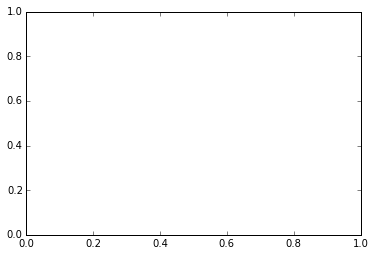

In [19]:
#hack = rain['ENTRIESn_hourly']
#plt.scatter(x=rain['datetime'], y=rain['ENTRIESn_hourly'])
#plt.xlabel("Length in mm")
#plt.ylabel("Efficiency in PPPC")
#plt.title("Average Food Pinching Efficiency by Chopstick Length")
#plt.show()

plt.figure()
plt.hist(x=rain['hour'], bins=15, color='violet')
plt.xlabel("Efficiency in PPPC")
plt.ylabel("Frequency")
plt.title("Average & Median Food Pinching Efficiency \nby Chopstick Length 240mm")
plt.show()


### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
You can combine the two histograms in a single plot or you can use two separate plots.
If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.


For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

## 3.2 One visualization can be more freeform. 

You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

## Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.

# Referenecs

Python 3.4.2 Documentation  Retrieved from https://docs.python.org/

ggplot from yhat Retrieved from http://ggplot.yhathq.com/

SciPy.org Retrieved from http://scipy.org/

Engineering Statistics Retrieved from http://www.itl.nist.gov/div898/handbook/

5.2.4.  Are the model residuals well-behaved? [Blog Post] Retrieved from http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

The Minitab Blog What Is the Difference between Linear and Nonlinear Equations in Regression Analysis? [Blog Post] Retrieved from http://blog.minitab.com/blog/adventures-in-statistics 

The Minitab Blog Regression Analysis how do I interpret R Squared and assess the goodness of fit. [Blog Post] Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

What are the differences between one-tailed and two-tailed tests? [Blog Post] Retrieved from http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm

Dummy Variables [Wiki Post] Retrieved from http://en.wikipedia.org/wiki/Dummy_variable_(statistics) 

Mann-Whitney U Test using SPSS [Blog Post] Retrieved from https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.phpRegression 

Analysis – How to Interpret the Constant Y Intercept [Blog Post] Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept 

Coding in the Rain [Blog Post] http://drjasondavis.com/2013/07/08/coding-in-the-rain/ 
